In [1]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import time
import random
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec
import seaborn as sns

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import BatchNormalization

In [2]:
def read_train_files(path: str) -> pd.DataFrame:  
    
    measurements = []
    dirnames = []
    
    for dirname, _, filenames in os.walk(path):
        if filenames:
            
            if not dirname[0:-4] in dirnames:
                    dirnames.append(dirname[0:-4])
                    print('Reading from {}'.format(dirname[0:-4]))
            
            for filename in filenames:
                file_path = os.path.join(dirname, filename)
                data = np.load(file_path)
                hanford = data[0][0::20]
                livingston = data[1][0::20]
                virgo = data[2][0::20]
                measurement_id = filename.replace('.npy', '')
                measurements.append([measurement_id, hanford, livingston, virgo])

    return pd.DataFrame(measurements, columns=['id', 'hanford', 'livingston', 'virgo'])

In [3]:
start_time = time.time()
measurements = read_train_files('/kaggle/input/g2net-gravitational-wave-detection/train/0')
end_time = time.time()
print('Read {} samples and it took {} seconds'.format(len(measurements), end_time - start_time))

Reading from /kaggle/input/g2net-gravitational-wave-detection/train/0
Read 35160 samples and it took 33.76961970329285 seconds


In [4]:
measurements = measurements.sort_values('id', ignore_index=True)
measurements.head(5)

,id,hanford,livingston,virgo
0,00000e74ad,"[-5.948305484407742e-21, -1.3697541524329667e-...","[9.754070475828088e-22, -6.822180753215815e-21...","[-1.74871982819324e-21, -8.847361433030346e-22..."
1,00001f4945,"[-1.2655739980298894e-21, -2.697930968573989e-...","[5.554405100496307e-22, -9.698123165990816e-21...","[-1.4536855032181174e-21, -2.296626036657779e-..."
2,0000661522,"[4.22990552405067e-21, 8.601895245069389e-21, ...","[6.457014420036976e-22, 1.0757770832989884e-20...","[-1.8556406226469758e-21, -2.038316308970535e-..."
3,00007a006a,"[-2.2973781494188274e-21, 3.77595748530619e-21...","[-8.467496710129497e-21, -5.582377725919879e-2...","[-9.208626033343402e-22, -6.230819908720723e-2..."
4,0000a38978,"[-2.2650777263353784e-20, -1.835626912760415e-...","[-2.1595564516344383e-21, 7.855497895359299e-2...","[-1.083355057903476e-21, 4.743192509469021e-22..."


In [5]:
labels = pd.read_csv('/kaggle/input/g2net-gravitational-wave-detection/training_labels.csv')
labels = labels.sort_values('id', ignore_index=True)

In [6]:
start_time = time.time()
measurements = pd.merge(measurements, labels, on="id")
end_time = time.time()
print('Merging tables took {} seconds'.format(len(measurements), end_time - start_time))

Merging tables took 35160 seconds


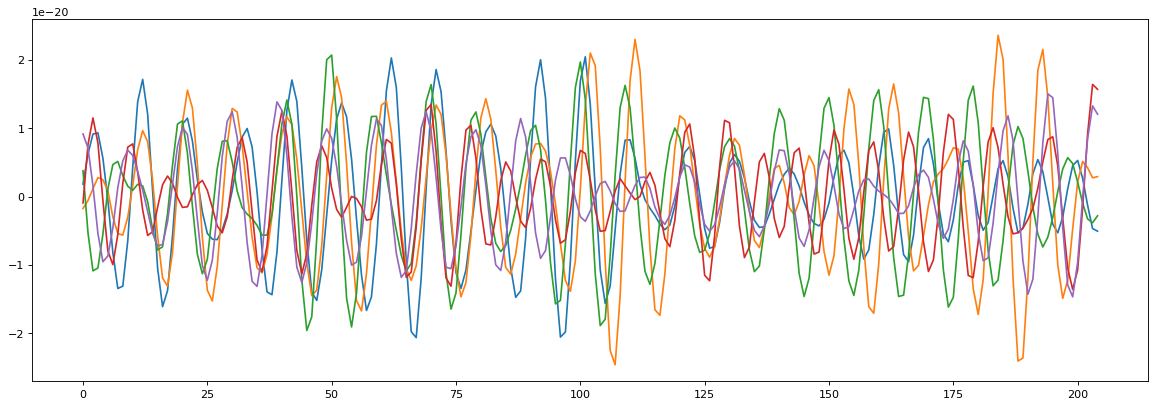

In [7]:
# Visualize some measurements
random.seed(10)
randoms = []
for i in range(0,5):
    randoms.append(random.randint(0, len(measurements)-1))

# Plotting randomly chosen 5 measurements
figure(figsize=(18, 6), dpi=80)
for i in randoms:
    plt.plot(measurements.loc[[i]]['hanford'].values[0])
plt.show()

In [15]:
# Checking for anomalies
means = []
medians = []
stds = []
sample_points = len(measurements['hanford'][0])
for index, row in measurements.iterrows():
    if len(row['hanford']) != sample_points or len(row['livingston']) != sample_points or len(row['virgo']) != sample_points:
        print(row)
    means.append([np.mean(row['hanford']), np.mean(row['livingston']), np.mean(row['virgo'])])
    medians.append([np.median(row['hanford']), np.median(row['livingston']), np.median(row['virgo'])])
    stds.append([np.std(row['hanford']), np.std(row['livingston']), np.std(row['virgo'])])

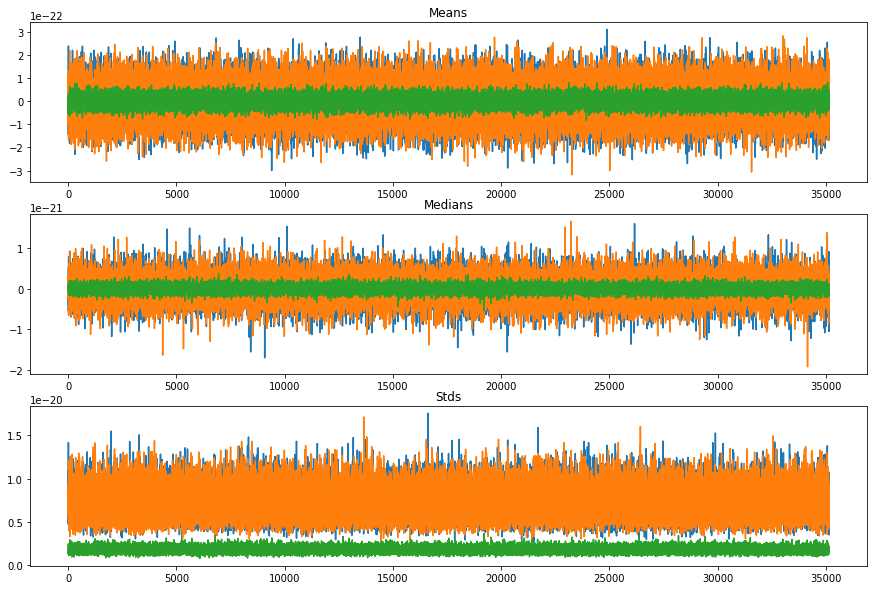

In [16]:
fig, axs = plt.subplots(3, figsize=(15,10))
axs[0].plot(means)
axs[0].set_title('Means')
axs[1].plot(medians)
axs[1].set_title('Medians')
axs[2].plot(stds)
axs[2].set_title('Stds')
plt.show()

In [17]:
del means
del medians
del stds 
gc.collect();

Modeling 

In [18]:
measurements = measurements.drop(['id'], axis=1)
measurements

,hanford,livingston,virgo,target
0,"[-5.948305484407742e-21, -1.3697541524329667e-...","[9.754070475828088e-22, -6.822180753215815e-21...","[-1.74871982819324e-21, -8.847361433030346e-22...",1
1,"[-1.2655739980298894e-21, -2.697930968573989e-...","[5.554405100496307e-22, -9.698123165990816e-21...","[-1.4536855032181174e-21, -2.296626036657779e-...",0
2,"[4.22990552405067e-21, 8.601895245069389e-21, ...","[6.457014420036976e-22, 1.0757770832989884e-20...","[-1.8556406226469758e-21, -2.038316308970535e-...",0
3,"[-2.2973781494188274e-21, 3.77595748530619e-21...","[-8.467496710129497e-21, -5.582377725919879e-2...","[-9.208626033343402e-22, -6.230819908720723e-2...",0
4,"[-2.2650777263353784e-20, -1.835626912760415e-...","[-2.1595564516344383e-21, 7.855497895359299e-2...","[-1.083355057903476e-21, 4.743192509469021e-22...",1
...,...,...,...,...
35155,"[-1.6907349477783336e-20, -1.782590932182012e-...","[-1.3522628840160134e-20, -6.058841090810444e-...","[-1.4548073994955685e-21, 1.5039327426561493e-...",1
35156,"[1.2043401662939327e-20, 1.619192947947937e-20...","[8.935830911258662e-21, 5.2262187346733966e-21...","[-4.238425757548087e-21, -3.745025699443359e-2...",0
35157,"[1.80551086107702e-21, -1.536520584863698e-21,...","[-8.013501189610687e-21, -9.352809221450472e-2...","[-4.793923935919679e-23, -8.718396416996909e-2...",1
35158,"[4.6232282943359154e-21, 1.0694660558757073e-2...","[-2.1655831970392565e-21, -3.6274225712552183e...","[1.4331735373981868e-21, 1.1751205415648195e-2...",1


In [19]:
X = np.asarray((measurements['hanford'].tolist(), measurements['livingston'].tolist(), measurements['virgo'].tolist()))
y = np.asarray(measurements['target'])

An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence. We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

In [23]:
X = np.swapaxes(np.swapaxes(X,0,1),1,2)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(28128, 205, 3)
(28128,)
(7032, 205, 3)
(7032,)


In [29]:
# Initialising the RNN
model=Sequential()

# Adding the first LSTM layer
model.add(LSTM(100, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Adding the second LSTM layer
#model.add(LSTM(400, return_sequences = True))
model.add(LSTM(100))
model.add(Dropout(0.2))

# Adding the third LSTM layer
#model.add(LSTM(400))
#model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(1, activation='sigmoid'))

# Compiling the RNN
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 205, 100)          41600     
_________________________________________________________________
dropout (Dropout)            (None, 205, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 122,101
Trainable params: 122,101
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
model.fit(X_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
440/440 [==============================] - 201s 448ms/step - loss: 0.6933 - accuracy: 0.4968 - auc: 0.4940
Epoch 2/3
440/440 [==============================] - 186s 423ms/step - loss: 0.6933 - accuracy: 0.5015 - auc: 0.5000
Epoch 3/3
440/440 [==============================] - 181s 412ms/step - loss: 0.6933 - accuracy: 0.5006 - auc: 0.4954


In [31]:
# Evaluation of the model
scores = model.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("AUC: %.2f" % (scores[2]))

Accuracy: 50.54%
AUC: 0.50


In [ ]:
del measurements 
del X 
del y 
del X_train
del X_val
del y_train
del y_val

gc.collect();

In [ ]:
def read_test_files_and_predict(path: str, model) -> pd.DataFrame:  
    
    predictions = pd.DataFrame(columns = ['id', 'target']) 
    dirnames = []
    for dirname, _, filenames in os.walk(path):
        if filenames:    
            
            if not dirname[0:-4] in dirnames:
                dirnames.append(dirname[0:-4])
                print('Reading from {}'.format(dirname[0:-4]))
            
            tests = []
            for filename in filenames:
                file_path = os.path.join(dirname, filename)
                data = np.load(file_path)
                hanford = data[0][0::10]
                livingston = data[1][0::10]
                virgo = data[2][0::10]
                test_id = filename.replace('.npy', '')
                tests.append([test_id, hanford, livingston, virgo])

            tests = pd.DataFrame(tests, columns=['id', 'hanford', 'livingston', 'virgo'])
            tests = tests.sort_values('id', ignore_index=True)
            test_ids = pd.DataFrame(tests['id'], columns=['id'])
            tests = tests.drop(['id'], axis=1)
            
            X_test = np.asarray((tests['hanford'].tolist(), tests['livingston'].tolist(), tests['virgo'].tolist()))
            X_test = np.swapaxes(X_test,0,1)
            X_test = np.swapaxes(X_test,1,2)
                    
            predictions = predictions.append(test_ids.join(pd.DataFrame(model.predict(X_test), columns=['target'])), ignore_index = True)
        
    return predictions

In [ ]:
start_time = time.time()
predictions = read_test_files_and_predict('/kaggle/input/g2net-gravitational-wave-detection/test/', model)
end_time = time.time()
print('Read and predicted {} test sampls and elapsed time: {}'.format(len(predictions), end_time - start_time))

Read and predicted 4096  test sampls and elapsed time: 2951.4087443351746

In [ ]:
predictions = predictions.sort_values('id')
predictions.to_csv('submission.csv', index = False)